In [1]:
cd Desktop\GPyOpt-master

/Users/ali/Desktop/GPyOpt-master


## Goal: Use Bayesian Optimization to find the optimal learning rate for a linear regression model. The credit for Bayesian Optimization library goes to GPyOpt...

In [13]:
%pylab inline
import GPyOpt
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
# create a Python list of feature names
feature_cols = ['TV', 'Radio', 'Newspaper']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# equivalent command to do this in one line
X = data[['TV', 'Radio', 'Newspaper']]
y = data['Sales']

# equivalent command that works if there are no spaces in the column name
y = data.Sales

# Split the dataset into train and test set

In [4]:
# split data to the train and test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## First, train a linear model and then look at RMSE and Learning rate

In [7]:
# train a linera model
from sklearn import linear_model
reg = linear_model.SGDRegressor(alpha = .002)
reg.fit (X_train,y_train) 
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
print("RMSE = "+str(np.sqrt(np.square(y_test_pred-y_test).mean())))
print ("Learnnig rate  = "+str(reg.alpha))

RMSE = 6.79910807027e+13
Learnnig rate  = 0.002


## Create an objective function to be minimized by Bayesian Optimization

In [14]:
nfold = 3
def fit_reg_val(x):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        for n in range(nfold):
            idx = np.array(range(X_train.shape[0]))
            idx_valid = np.logical_and(idx>=X_train.shape[0]/nfold*n, idx<X_train.shape[0]/nfold*(n+1))
            idx_train = np.logical_not(idx_valid)
            reg = linear_model.SGDRegressor (alpha = x[i,0])
            reg.fit(X_train[idx_train],y_train[idx_train])
            fs[i] += np.sqrt(np.square(reg.predict(X_train[idx_valid])-y_train[idx_valid]).mean())
        fs[i] *= 1./nfold
    return fs

## The desciosn variable is Learnnig rate denoted by "alpha". We set a feasible range for it

In [15]:
# feasible domain for learning rate
domain  =[{'name': 'alpha','type': 'continuous', 'domain': (0,0.1)}]

## Create a Bayesain Optimization object. Amonge various choices for acqusiotion function, I have used a Lower Confidence Bound (LCB) for this problem.

In [16]:
# Bayesain Optimization object
opt = GPyOpt.methods.BayesianOptimization(f = fit_reg_val,                 
                                          domain = domain,         
                                          acquisition_type ='LCB')       

The set cost function is ignored! LBC acquisition does not make sense with cost.


## Run Bayesain Optimization. The number of budget iterations is set to 20.

In [17]:
# run Bayesain Optimization
opt.run_optimization(max_iter= 20)

## See the convergence...

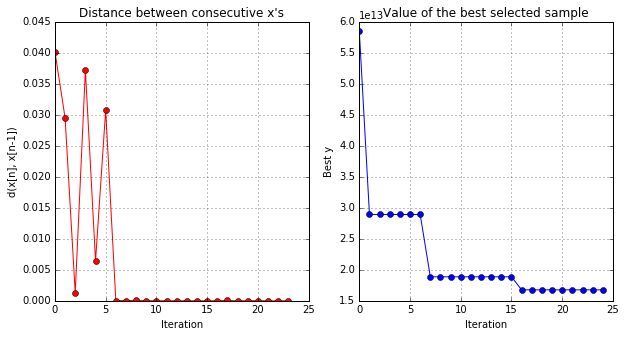

In [18]:
opt.plot_convergence()

## Let's again train the model with optimal Learning rate and see RMSE

In [19]:
# Train the model with optimal learning rate
x_best = (opt.X[np.argmin(opt.Y)])
reg = linear_model.SGDRegressor (alpha = x_best[0])
reg.fit (X_train,y_train) 
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
print("RMSE = "+str(np.sqrt(np.square(y_test_pred-y_test).mean())))
print reg.alpha

RMSE = 7.71411442384e+12
0.0625751691755
